In [1]:
#Importing required packages
import pandas as pd
import numpy as np
import urllib.request
import requests
import os
import cv2 #This module will help in converting and resizing the movie posters to 224x224 numpy arrays
from IPython.display import Image 
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import re

We now load the IMDB interface file where the columns are separated by a tab space.

In [33]:
d = pd.read_csv('data.csv', sep='\t', header = 0)

C:\Users\Aditya\Miniconda2\envs\py3point6\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The first five rows of this dataset have been printed below. Each title is identified by a unique 'tconst', which is the IMDB ID. The 'startYear' and 'endYear' fields are more important for TV shows. For movies, the 'endYear' field does not contain a valid value.

In [34]:
d.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


Only fields of importance are separated out from the original dataframe.

In [35]:
d1 = d[['tconst', 'titleType', 'originalTitle', 'startYear', 'genres']]

Only movies are to considered for this analysis. Hence, the line of code below to achieve the same.

In [36]:
d1 = d1.loc[d1.titleType =='movie']

In [37]:
len(d1)

505039

In [38]:
d1 = d1.dropna()

The pandas dataframe below captures information of movies from the 60s.

In [39]:
d3 = d1.loc[(d1.startYear.str.contains('196')) | (d1.startYear.str.contains('197')) | (d1.startYear.str.contains('198')) | (d1.startYear.str.contains('199')) | (d1.startYear.str.contains('200')) | (d1.startYear.str.contains('201'))]

The movies are sorted in ascending order by year.

In [40]:
d3  = d3.sort_values('startYear')

Since the goal is to classify mainstream movies, documentaries will not be considered for analysis.

In [41]:
d5 = d3.loc[d3.genres.str.contains('Documentary') == False]

In [42]:
len(d5)

269662

Movie posters after 2012 are to downloaded for the model. The dataframe below identifies all regular mainstream movies from 2013.

In [43]:
full_list = d5.loc[d5.startYear > '2012']

In [44]:
len(full_list)

68588

Talk shows, adult movies, News, and other such rare genres will be excluded from analysis. The poster of a 'Talk-Show' movie would perhaps be identified as "Drama" by the classification model. 'Talk-Shows' as a genre can't be explicitly identified lke action, horror, adventure, commedy or animation movies. The other genres have been excluded for the very same reasons.

In [45]:
full_list_1 = full_list.loc[(full_list.genres.str.contains('Talk-Show') == False) & (full_list.genres.str.contains('Adult') == False) & (full_list.genres.str.contains('News') == False) & (full_list.genres.str.contains('Western') == False) & (full_list.genres.str.contains('Reality-TV') == False) & (full_list.genres.str.contains('Short') == False) & (full_list.genres.str.contains('Game-Show') == False)]

In [46]:
len(full_list_1)

67817

A small subset of the modified pandas datafame has been printed below.

In [47]:
full_list_1.head(11)

,tconst,titleType,originalTitle,startYear,genres
4313807,tt6964088,movie,201314,2013,\N
4336272,tt7012128,movie,"L'acteur, l'arnaqueur",2013,Action
4404919,tt7158090,movie,Killing 7,2013,Thriller
4478728,tt7315746,movie,Jeolmeun eomma,2013,"Drama,Romance"
4361583,tt7066046,movie,Left,2013,\N
4277603,tt6886920,movie,The Bringer of Light,2013,"Horror,Sci-Fi"
4313389,tt6963172,movie,Tjuvgods,2013,\N
5286823,tt9032082,movie,M-Agent,2013,"Horror,Mystery,Thriller"
2929940,tt3887836,movie,A Blossom of Love in Gannan,2013,Romance
4290679,tt6915090,movie,Pavithra,2013,Thriller


From the above subset dataframe, one can observe that a '\N' has been assigned in genres column. This isn't labeled data and since the goal is to use supervised learning, all such rows will be excluded from analysis. The code below identifies all such rows using pattern matching.

In [48]:
full_list_1['genres_2'] = full_list_1['genres'].apply(re.compile(r'\\N').search)

C:\Users\Aditya\Miniconda2\envs\py3point6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


A null is returned for the genres column where the pattern isn not identified. Hence, these rows will be selected for our analysis thereby dropping the rows with '\N' for genre

In [49]:
full_list_2 = full_list_1.loc[full_list_1.genres_2.isnull()]

In [50]:
len(full_list_2)

63670

The index has been reset after the necessary rows have been dropped.

In [51]:
full_list_2 = full_list_2.reset_index()

In [52]:
full_list_2 = full_list_2.drop(['index'], axis=1)

In [53]:
len(full_list_2)

63670

An empty list, genres_list has been created below. This list will be used to identify the different genres in our interface file.

In [54]:
genres_list = []

In [55]:
for j in full_list_2['genres']:     #Looping over the genres column of the dataframe.
    words = j.split(',')            #The different genres have been separated by a comma. Hence this string will be split by identifying the ',' character.
    for k in words:                 #Since the different list of words will be identified, the for loop will be used to iterate through all the different words in this list.
        if k not in genres_list:    #Only uniquely identified strings will be appended.
            genres_list.append(k)

In [56]:
len(genres_list)

19

The genres list has been printed below. This list identifies the different genres in our interface file.

In [57]:
genres_list

['Action',
 'Thriller',
 'Drama',
 'Romance',
 'Horror',
 'Sci-Fi',
 'Mystery',
 'Adventure',
 'Animation',
 'Crime',
 'Comedy',
 'Fantasy',
 'Family',
 'Music',
 'History',
 'War',
 'Musical',
 'Biography',
 'Sport']

A new dictionary, genres_dict has been created to identify the counts of each of the genres. It is important to note that a single movie could belong to more than one genre.

In [58]:
genres_dict = {}

In [59]:
for j in full_list_2['genres']:    #Looping over the genres column
    words = j.split(',')           #Identifying the different genres
    for k in words:
        if k not in genres_dict:   #If the genre doesn't exist, it will be created as a new key
            genres_dict[k] = 1    
        else:
            genres_dict[k] += 1            

The dictionary, genres_dict has been printed below to identify counts of the various genres. It is important to note that summing the individual counts for each genre will not add up to the total length of the dataframe. This is because most movies belong to more than one genre.

In [60]:
genres_dict

{'Action': 6865,
 'Thriller': 8874,
 'Drama': 31832,
 'Romance': 6305,
 'Horror': 7809,
 'Sci-Fi': 2540,
 'Mystery': 3208,
 'Adventure': 3241,
 'Animation': 2019,
 'Crime': 4399,
 'Comedy': 16691,
 'Fantasy': 2470,
 'Family': 3088,
 'Music': 1193,
 'History': 1229,
 'War': 579,
 'Musical': 816,
 'Biography': 1467,
 'Sport': 637}

Next, the genres_2 column has been excluded as this column was only used to identify rows with a '\N' for genre. It is no longer needed.

In [61]:
full_list_2 = full_list_2.drop(['genres_2'], axis = 1)

A string, 'Numpy_Img' has been added to the genres_list. This list will be used to create a new Pandas dataframe.

In [62]:
genres_list.append('Numpy_Img')

The pandas dataframe has been created with 40000 rows with NaN values.

In [63]:
genres_df = pd.DataFrame(columns=genres_list, index=range(40000))

The TMDB (The Movies Database) API will be used to download movie posters. To download the posters, the TMDB API key is required. It is a site that is free to use with registration.

In [64]:
KEY = 'a997c6a74e5b2d33c1e329b556a1769d'

The next cell will give a verbose description of what the count variable, 'count_var' is and how the posters will be downloaded.

The count_var will be used to identify the index of the now empty genres dataframe. For each uniquely identified index, The Numpy_Img column will contain the movie poster resized to 224x224 with the RGB channel information intact. The other columns in the dataframe are the 19 uniquely identified genres. If a movie belong to the genres, 'Action' and 'Adventure', then the 'Action' and 'Adventure' columns will be assigned a 1.0. The other genre columns will contain a 0. Simply considering the genre columns, one could think of this as a sparse matrix as this matrix mostly contains 0s.

In [65]:
count_var = 0

In [82]:
for index, i in full_list_2.iterrows():      # Looping over the modified interface file with mainstream movies after 2012
    IMG_PATTERN = 'http://api.themoviedb.org/3/movie/{imdbid}/images?api_key={key}' # The URL pattern for the movie posters. With the key and IMDB ID, the generated URL can be used to download the posters.
    r = requests.get(IMG_PATTERN.format(key=KEY,imdbid=i[0])) # KEY is the API key and i[0] identifies the unique IMDB ID.
    api_response = r.json() # The generated response is converted to json.
    try:                    # Some of the movies do not contain any information and much less, any posters. Hence, exception handling will be used to avoid errors during runtime
        posters = api_response['posters'] # Contains information about the movie posters to be downloaded.
    except KeyError:
        continue            # 'continue' can only be used in a loop. This command moves on the next row if no vible information is found.
    
    base_url = 'http://image.tmdb.org/t/p/'  # The base url for the TMDB API
    max_size = 'w342'                        # Movie sizes are available in different sizes: w342, w500, and orignal. w342 images are smaller than w500 and 'original' images.
    try:                                     # Some movies do not have posters and hence, exception handling will be used to avoid runtime errors
        rel_path = posters[0]['file_path']   # Some movies have multiple posters. A few movies have up to 9 posters or so. What's even more bothersome is that some of them are duplicates. Hence, onlyone image per movie will be used.
    except IndexError:
        continue
    url = "{0}{1}{2}".format(base_url, max_size, rel_path) # If the movie does have a poster, this step generated the movie poster url
      
    try:                                                          #Exception handling will be used since some of the URLs will not open or throw an error.
        resp = urllib.request.urlopen(url)                        # This step read the image from the url
        image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
        new_img = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC) # Images re resized using Inter_cubic interpolation.
        
        someRowNumber = count_var # To each identify each index.
        words = i[4].split(',')   # Identify the different genres        
        genres_df.loc[genres_df.index[someRowNumber], 'Numpy_Img'] = new_img #The Numpy_Img column will contain the 224x224 resized posters.
        for k in words:
            genres_df.loc[genres_df.index[someRowNumber], k] = 1.0 #A 1.0 will be assigned to that genre column.
        count_var+=1  # The count variable will be reset so that the next row will be used for the next movie.
        print(index)  # Printing the index to keep track of progress.
    except urllib.error.URLError as e:
        print(e.reason)       
        
collected_images = genres_df.loc[genres_df['Numpy_Img'].notnull()] # Identify only rows that contain movie data.
collected_images_df = collected_images.fillna(0)                   # NaN values for the genre columns are filled with 0.
collected_images_df.to_pickle('frame_1.pkl')                       # The dataframe is exported to a pickle file.

11
15
28
33
65
66
67
68
78
86
98


The dataframe will now be loaded back

In [83]:
genres_dataframe = pd.read_pickle('frame_1.pkl')

In [84]:
len(genres_dataframe)

23

In [85]:
genres_dataframe.head(2)

,Action,Thriller,Drama,Romance,Horror,Sci-Fi,Mystery,Adventure,Animation,Crime,Comedy,Fantasy,Family,Music,History,War,Musical,Biography,Sport,Numpy_Img
0,0,0.0,0.0,0,0.0,1.0,0,0.0,1.0,0,0.0,0,0.0,0,0,0,0,0,0.0,"[[[4, 0, 1], [4, 0, 0], [4, 0, 0], [3, 1, 0], ..."
1,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,1.0,0,0.0,0,0,0,0,0,0.0,"[[[58, 194, 170], [58, 194, 170], [58, 194, 17..."


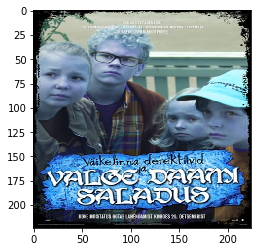

In [89]:
plt.imshow(genres_dataframe['Numpy_Img'].loc[7])

In [9]:
genres_dataframe['Numpy_Img'].loc[100].shape

(224, 224, 3)

In [10]:
type(genres_dataframe['Numpy_Img'].loc[100])

numpy.ndarray